# Import Library

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image

%matplotlib inline

# Download and Extract Dataset

In [2]:
base_dir = 'image-model-2/'
os.listdir(base_dir)

['bopeng', 'jerawat', 'normal']

In [3]:
file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split("/")[-1])
        file_name.append(name)


In [4]:
df = pd.DataFrame({"path": full_path, "file_name": file_name, "tag": tag})
df.groupby(["tag"]).size()


tag
bopeng     481
jerawat    495
normal     482
dtype: int64

In [5]:
X = df["path"]
y = df["tag"]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=123, stratify=y)

In [7]:
data_train = pd.DataFrame({"path": X_train, "tag": y_train, "set": "train"})
data_test = pd.DataFrame({"path": X_test, "tag": y_test, "set": "test"})


In [8]:
print("train size", len(data_train))
print("test size", len(data_test))


train size 1312
test size 146


In [9]:
# Melihat proporsi training dan validation set
df_all = data_train.append([data_test]).reset_index(drop=1)
print(df_all.groupby(["set", "tag"]).size(), "\n")

# Cek sample data
df_all.sample(3)

set    tag    
test   bopeng      48
       jerawat     50
       normal      48
train  bopeng     433
       jerawat    445
       normal     434
dtype: int64 



C:\Users\User\AppData\Local\Temp\ipykernel_4896\3928688440.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = data_train.append([data_test]).reset_index(drop=1)


,path,tag,set
1174,image-model-2/bopeng\b_0_64.jpg,bopeng,train
1304,image-model-2/normal\n_0_3676.jpg,normal,train
284,image-model-2/jerawat\j_0_254.jpg,jerawat,train


In [10]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)


In [11]:
train_generator = train_datagen.flow_from_dataframe(
        data_train,
        x_col="path",
        y_col="tag",
        target_size=(200, 200),
        batch_size=131,
        class_mode="categorical",
        shuffle=True
)

validation_generator = validation_datagen.flow_from_dataframe(
        data_test,
        x_col="path",
        y_col="tag",
        target_size=(200, 200),
        batch_size=14,
        class_mode="categorical",
        shuffle=True
)

Found 1312 validated image filenames belonging to 3 classes.
Found 146 validated image filenames belonging to 3 classes.


# Callback Function

In [12]:
ACCURACY_THRESHOLD = 0.99


class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") > ACCURACY_THRESHOLD:
            print(
                "\nReached %2.2f%% accuracy, training stopped!"
                % (ACCURACY_THRESHOLD * 100)
            )
            self.model.stop_training = True


callbacks = Callback()

# Building Model

In [13]:
# model = tf.keras.models.Sequential(
#     [
#         tf.keras.layers.Conv2D(
#             32, (3, 3), activation="relu", input_shape=(200, 200, 3)
#         ),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(512, activation="relu"),
#         tf.keras.layers.Dense(3, activation="softmax"),
#     ]
# )


In [13]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            16,
            (3, 3),
            strides=(2, 2),
            activation="relu",
            padding="same",
            input_shape=(200, 200, 3),
            kernel_initializer="he_normal",
            bias_initializer="zeros",
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            strides=(2, 2),
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
            bias_initializer="zeros",
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            strides=(2, 2),
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
            bias_initializer="zeros",
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            strides=(2, 2),
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
            bias_initializer="zeros",
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            128,
            (3, 3),
            strides=(2, 2),
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
            bias_initializer="zeros",
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dense(3, activation=tf.nn.softmax),
    ]
)


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

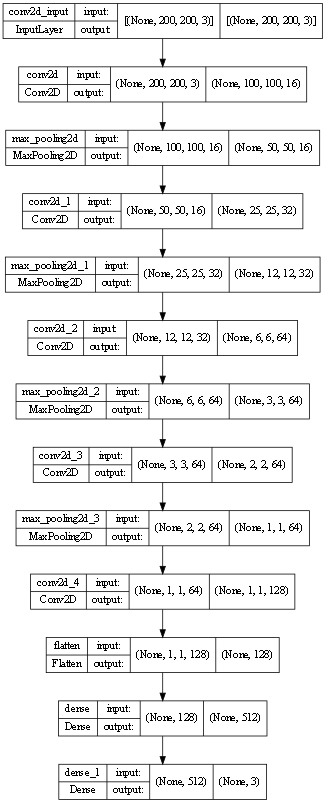

In [15]:
model_viz = tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=55,
)
model_viz

In [16]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [17]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=20,
      verbose=2,
      validation_data=validation_generator,
      validation_steps=10,
      callbacks=[callbacks],
)


Epoch 1/20
10/10 - 5s - loss: 1.0949 - accuracy: 0.3590 - val_loss: 1.0678 - val_accuracy: 0.3714 - 5s/epoch - 462ms/step
Epoch 2/20
10/10 - 4s - loss: 1.0545 - accuracy: 0.4361 - val_loss: 1.0623 - val_accuracy: 0.3571 - 4s/epoch - 391ms/step
Epoch 3/20
10/10 - 4s - loss: 1.0280 - accuracy: 0.4996 - val_loss: 0.9436 - val_accuracy: 0.6929 - 4s/epoch - 396ms/step
Epoch 4/20
10/10 - 4s - loss: 0.8993 - accuracy: 0.6410 - val_loss: 0.8283 - val_accuracy: 0.6571 - 4s/epoch - 401ms/step
Epoch 5/20
10/10 - 4s - loss: 0.7513 - accuracy: 0.6562 - val_loss: 0.7484 - val_accuracy: 0.6286 - 4s/epoch - 414ms/step
Epoch 6/20
10/10 - 4s - loss: 1.2109 - accuracy: 0.6139 - val_loss: 1.1293 - val_accuracy: 0.4071 - 4s/epoch - 408ms/step
Epoch 7/20
10/10 - 4s - loss: 1.0673 - accuracy: 0.4776 - val_loss: 1.0227 - val_accuracy: 0.5214 - 4s/epoch - 403ms/step
Epoch 8/20
10/10 - 4s - loss: 0.9407 - accuracy: 0.5834 - val_loss: 0.8563 - val_accuracy: 0.7214 - 4s/epoch - 399ms/step
Epoch 9/20
10/10 - 4s - 

# Model Accuracy

In [18]:
test_loss, test_acc = model.evaluate(validation_generator)
print("\naccuracy:", test_acc, "  loss: ", test_loss)


11/11 [==============================] - 0s 33ms/step - loss: 0.0481 - accuracy: 0.9932

accuracy: 0.9931507110595703   loss:  0.048105306923389435


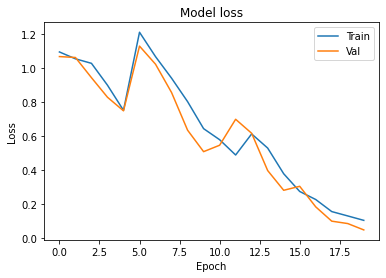

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

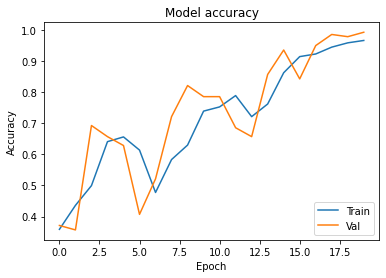

In [20]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="lower right")
plt.show()

# Making Prediction

[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[4.4388074e-25 0.0000000e+00 1.0000000e+00]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[2.7088047e-04 0.0000000e+00 9.9972910e-01]
[0. 0. 1.]
[0. 0. 1.]


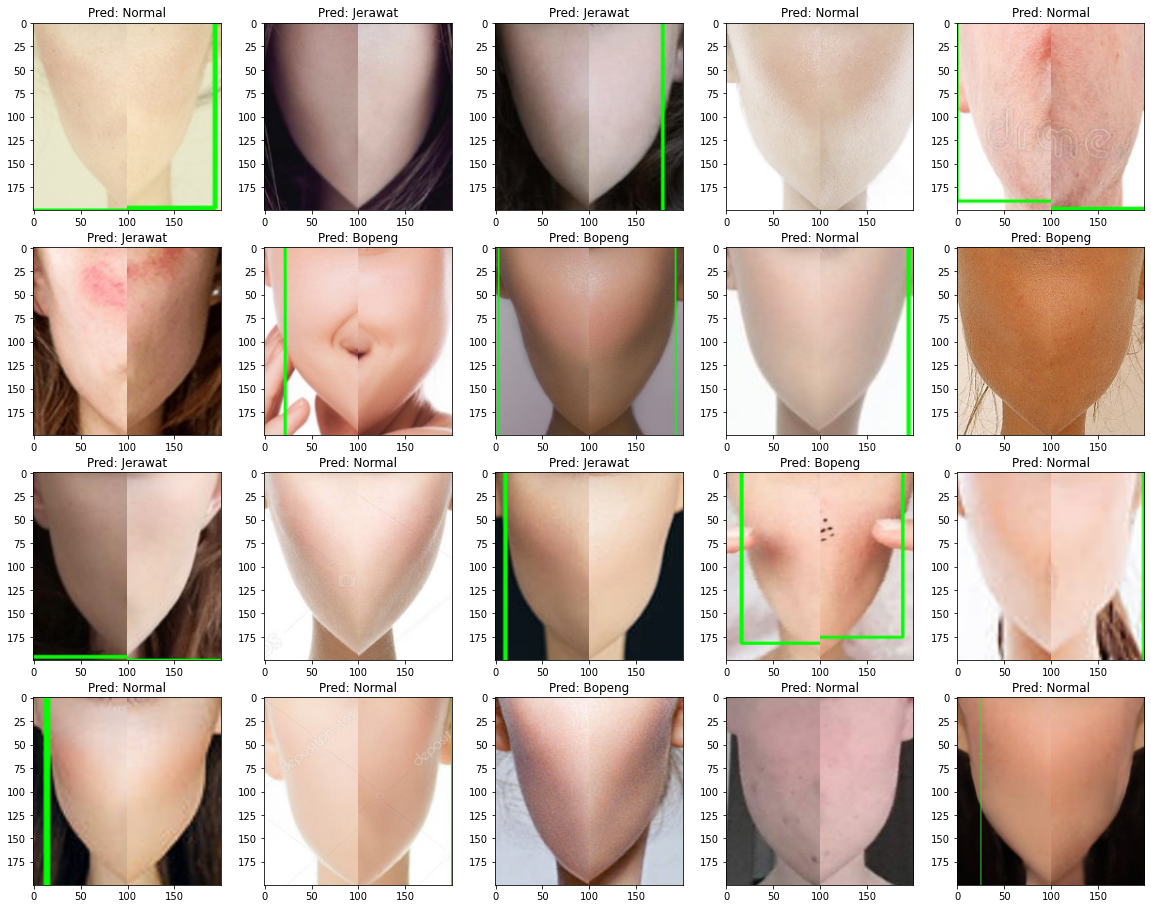

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

m = 1
columns = 5
rows = 5
directory = 'image-test-cropped/test-model-2'
pred_labels = ""
# iterate over files in
# that directory
fig = plt.figure(figsize=(20, 20))
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img = image.load_img(f, target_size=(200, 200))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)
        print(classes[0])
        if classes[0,0]!=0:
            pred_labels = 'Bopeng'
        elif classes[0,1]!=0:
            pred_labels = 'Jerawat'
        else:
            pred_labels = 'Normal'
            
        fig.add_subplot(rows, columns, m)
        plt.imshow(img)
        plt.title("Pred: " + pred_labels)
        m += 1

In [22]:
y_pred = model.predict(validation_generator)
y_pred = np.round(y_pred, 0)

In [23]:
y_pred

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0

In [24]:
y_pred_labels = []

for value in range(len(y_pred)):
    if y_pred[value, 0] != 0:
        y_pred_labels.append(0)
    elif y_pred[value, 1] != 0:
        y_pred_labels.append(1)
    else:
        y_pred_labels.append(2)

y_pred_labels

[0,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 2,
 1,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 1]

In [25]:
y_test.replace(['bopeng', 'jerawat', 'normal'], [0, 1, 2], inplace=True)
y_test

1349    2
993     2
1247    2
1352    2
1227    2
       ..
1360    2
934     1
489     1
348     0
1176    2
Name: tag, Length: 146, dtype: int64

In [26]:
categorical = ['bopeng', 'jerawat', 'normal']
classification_metrics = classification_report(y_pred_labels, y_test, target_names=categorical)
print(classification_metrics)

              precision    recall  f1-score   support

      bopeng       0.35      0.35      0.35        48
     jerawat       0.36      0.37      0.36        49
      normal       0.40      0.39      0.39        49

    accuracy                           0.37       146
   macro avg       0.37      0.37      0.37       146
weighted avg       0.37      0.37      0.37       146



In [27]:
cf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_df = pd.DataFrame(
    cf_matrix,
    index=["Bopeng", "Jerawat", "Normal"],
    columns=["Bopeng", "Jerawat", "Normal"]
)

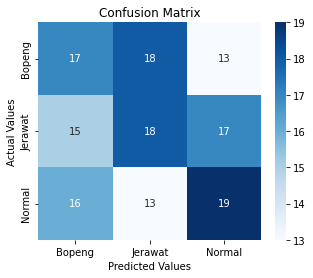

In [28]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Save the Model

In [24]:
# MODEL_BASE_PATH = "model"
# PROJECT_NAME = "ausion_project"
# SAVE_MODEL_NAME = "acpock-model.h5"
# save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
# if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
#     os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

# print("Saving Model At {}...".format(save_model_path))
# model.save(save_model_path, include_optimizer=False)


Saving Model At model\ausion_project\acpock-model.h5...
